# **Homework2 - Denoising Diffusion Probabilistic Model**

This is the sample code of homework 2 of the IMVFX course by Prof. I-Chen Lin

In this section, you are required to build a diffusion network for image generation.

If you have any questions, please contact the TA via 1999joehuang@gmail.com

Sample code for DDPM, include the structure and train function. You can start form this file or write your own structure and train function. You can also modify anything in this file for training.

What you need to do:

1. Load MNIST dataset.
2. Train the DDPM and generate images in 5*5 grid.
3. Plot the loss of DDPM.
4. Load the anime face dataset.
5. Design the DDPM process for the anime face dataset and perform the same steps as in step 2 & 3.

For more details, please reference to DDPMPractice.pdf.

If you are not familiar with Colab, [here](https://colab.research.google.com/drive/1GYNIgctFaYsxyuK2RqfRda1M0Qk-jhvL#scrollTo=enB7U8b9Z1WA) provide the basic Colab knowledge needed to finish this homework.

# Set up the environment



### Packages Installation

In [1]:
# You may replace the workspace directory if you want
workspace_dir = '.'

# Library for handling tensor operations
!pip install einops

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.2 MB/s eta 0:00:00


### Download the dataset

Download dataset via **gdown**.

You need to download the MNIST dataset and the Anime Face dataset.

Or you can download datasets from google drive <br/> MNIST dataset: https://drive.google.com/file/d/16j8CG2FxVIUGpn4ZmocCl_wNj9VGv6FM/view?usp=drive_link <br/> Anime Face dataset: https://drive.google.com/file/d/1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ/view?usp=drive_link

In [2]:
!pip install gdown
# MNIST dataset
!gdown --id 16j8CG2FxVIUGpn4ZmocCl_wNj9VGv6FM --output "{workspace_dir}/mnist.zip"

# Anime Face dataset
!gdown --id 1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ --output "{workspace_dir}/anime_face.zip"

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=16j8CG2FxVIUGpn4ZmocCl_wNj9VGv6FM
From (redirected): https://drive.google.com/uc?id=16j8CG2FxVIUGpn4ZmocCl_wNj9VGv6FM&confirm=t&uuid=4c89a453-c875-46f5-90a2-643016066f3c
To: /kaggle/working/mnist.zip
100%|███████████████████████████████████████| 42.6M/42.6M [00:00<00:00, 115MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ
From (redirected): https://drive.google.com/uc?id=1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ&confirm=t&uuid=6ef33f6d-3561-4978-9c60-4c98

###Unzip the downloaded file.


The unzipped tree structure is like:
```
mnist_dataset/
  data/
    0/
    ├── 1.jpg
    ├── 21.jpg
    ├── 34.jpg
    ├── ...
    ...
```

```
anime_face_dataset/
  data/
  ├── 1.png
  ├── 2.png
  ├── 3.png
  ├── ...
```

In [3]:
!unzip -o -q "{workspace_dir}/mnist.zip" -d "{workspace_dir}/mnist_dataset"
!unzip -o -q "{workspace_dir}/anime_face.zip" -d "{workspace_dir}/anime_face_dataset"

# Random seed

Set the random seed to a certain value for reproducibility.

In [4]:
import random

import torch
import numpy as np

def same_seeds(seed):
  # Python built-in random module
  random.seed(seed)
  # Numpy
  np.random.seed(seed)
  # Torch
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

# Set random seed for reproducibility
same_seeds(999)

# Import packages

First, we need to import packages that will be used later.

In [5]:
# Import packages
import numpy as np
import cv2
import einops
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda, Grayscale
from torchvision.datasets import ImageFolder

# Hyperparameters and Initialization

Define some inputs for the run later.

In [6]:
# Root directory for the MNIST dataset
dataset_path = f"{workspace_dir}/mnist_dataset"

# The path to save the model
model_store_path = f"{workspace_dir}/mnist.pt"

# Batch size during training
batch_size = 128

# Number of training epochs
n_epochs = 30

# Learning rate for optimizers
lr = 0.0005

# Number of the forward steps
n_steps = 1000

# Initial beta
start_beta = 1e-4

# End beta
end_beta = 0.02

# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# List to keep track of loss
loss_list = []

Device: cuda


# Dataset

### Create the dataset and data loader.

In [7]:
# Load the data, convert it to grayscale, and then normalize it to the range of [-1, 1]
dataset = ImageFolder(root=dataset_path, transform=Compose([
    Grayscale(),
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
))

# Make the data loader
dataloader = DataLoader(dataset, batch_size, shuffle=True)

### Show some images

The shape of images:  (128, 1, 28, 28)


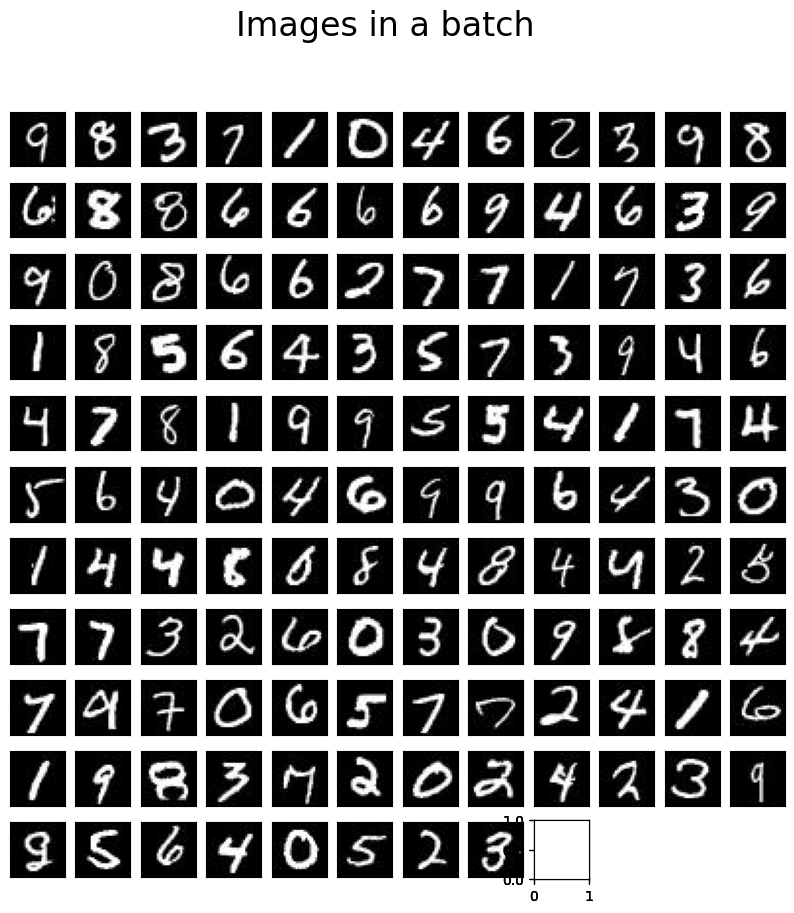

In [8]:
# Show images
def show_images(images, title=""):
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
    print("The shape of images: ", images.shape)
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title, fontsize=24)
    rows = int(len(images) ** 0.5)
    cols = round(len(images) / rows)
    index = 0
    for row in range(rows):
        for col in range(cols):
            fig.add_subplot(rows, cols, index + 1)
            if index < len(images):
                frame = plt.gca()
                frame.axes.get_yaxis().set_visible(False)
                frame.axes.get_xaxis().set_visible(False)
                temp = np.transpose(images[index], (1, 2, 0))
                plt.imshow((temp+1)/2, cmap='gray')
                index += 1
    plt.show()

# Show images of next batch
def show_images_of_next_batch(loader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    features, labels = data
    show_images(features, "Images in a batch")

show_images_of_next_batch(dataloader)

# Model

Here, we constructed a noise predictor using a simple U-Net architecture to generate handwritten numbers.

If you want to achieve better results, you need to design more complex models yourself.

Feel free to modify your own model structure!

### DDPM

In [9]:
# Define the class of DDPM
class DDPM(nn.Module):
    def __init__(self, image_shape=(1, 28, 28), n_steps=200, start_beta=1e-4, end_beta=0.02, device=None):
        super(DDPM, self).__init__()
        self.device = device
        self.image_shape = image_shape
        self.n_steps = n_steps
        self.noise_predictor = UNet(n_steps).to(device)
        self.betas = torch.linspace(start_beta, end_beta, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    # Forward process
    # Add the noise to the images
    def forward(self, x0, t, eta=None):
        n, channel, height, width = x0.shape
        alpha_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, channel, height, width).to(self.device)

        noise = alpha_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - alpha_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noise

    # Backward process
    # Predict the noise that was added to the images during the forward process
    def backward(self, x, t):
        return self.noise_predictor(x, t)

### Time embedding

In [10]:
# Create the time embedding
def time_embedding(n, d):
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])
    return embedding

### Noise predictor

In [11]:
# Define the class of U-Net
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_embedding_dim=256):
        super(UNet, self).__init__()

        # Time embedding
        self.time_step_embedding = nn.Embedding(n_steps, time_embedding_dim)
        self.time_step_embedding.weight.data = time_embedding(n_steps, time_embedding_dim)
        self.time_step_embedding.requires_grad_(False)

        # The first half
        self.time_step_encoder1 = nn.Sequential(
            nn.Linear(time_embedding_dim, 1),
            nn.SiLU(),
            nn.Linear(1, 1)
        )

        self.block1 = nn.Sequential(
            nn.LayerNorm((1, 28, 28)),
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.down1 = nn.Conv2d(8, 8, 4, 2, 1)

        self.time_step_encoder2 = nn.Sequential(
            nn.Linear(time_embedding_dim, 8),
            nn.SiLU(),
            nn.Linear(8, 8)
        )

        self.block2 = nn.Sequential(
            nn.LayerNorm((8, 14, 14)),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.down2 = nn.Conv2d(16, 16, 4, 2, 1)

        self.time_step_encoder3 = nn.Sequential(
            nn.Linear(time_embedding_dim, 16),
            nn.SiLU(),
            nn.Linear(16, 16)
        )

        self.block3 = nn.Sequential(
            nn.LayerNorm((16, 7, 7)),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(32, 32, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, 4, 2, 1)
        )

        # The bottleneck
        self.time_step_encoder_mid = nn.Sequential(
            nn.Linear(time_embedding_dim, 32),
            nn.SiLU(),
            nn.Linear(32, 32)
        )

        self.block_mid = nn.Sequential(
            nn.LayerNorm((32, 3, 3)),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )

        # The second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 32, 2, 1)
        )

        self.time_step_encoder4 = nn.Sequential(
            nn.Linear(time_embedding_dim, 64),
            nn.SiLU(),
            nn.Linear(64, 64)
        )

        self.block4 = nn.Sequential(
            nn.LayerNorm((64, 7, 7)),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )

        self.up2 = nn.ConvTranspose2d(16, 16, 4, 2, 1)

        self.time_step_encoder5 = nn.Sequential(
            nn.Linear(time_embedding_dim, 32),
            nn.SiLU(),
            nn.Linear(32, 32)
        )

        self.block5 = nn.Sequential(
            nn.LayerNorm((32, 14, 14)),
            nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )

        self.up3 = nn.ConvTranspose2d(8, 8, 4, 2, 1)

        self.time_step_encoder6 = nn.Sequential(
            nn.Linear(time_embedding_dim, 16),
            nn.SiLU(),
            nn.Linear(16, 16)
        )
        self.block6 = nn.Sequential(
            nn.LayerNorm((16, 28, 28)),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.LayerNorm((8, 28, 28)),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )

        self.final_layer = nn.Conv2d(8, 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_step_embedding(t)
        n = len(x)
        output1 = self.block1(x + self.time_step_encoder1(t).reshape(n, -1, 1, 1))
        output2 = self.block2(self.down1(output1) + self.time_step_encoder2(t).reshape(n, -1, 1, 1))
        output3 = self.block3(self.down2(output2) + self.time_step_encoder3(t).reshape(n, -1, 1, 1))
        output_mid = self.block_mid(self.down3(output3) + self.time_step_encoder_mid(t).reshape(n, -1, 1, 1))
        output4 = torch.cat((output3, self.up1(output_mid)), dim=1)
        output4 = self.block4(output4 + self.time_step_encoder4(t).reshape(n, -1, 1, 1))
        output5 = torch.cat((output2, self.up2(output4)), dim=1)
        output5 = self.block5(output5 + self.time_step_encoder5(t).reshape(n, -1, 1, 1))
        output6 = torch.cat((output1, self.up3(output5)), dim=1)
        output6 = self.block6(output6 + self.time_step_encoder6(t).reshape(n, -1, 1, 1))
        output = self.final_layer(output6)
        return output

# Train

### Initialization

In [12]:
# Build the DDPM
ddpm_mnist = DDPM(n_steps=n_steps, start_beta=start_beta, end_beta=end_beta, device=device)

# Print the model
print(ddpm_mnist)

DDPM(
  (noise_predictor): UNet(
    (time_step_embedding): Embedding(1000, 256)
    (time_step_encoder1): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
    (block1): Sequential(
      (0): LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)
      (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2)
    )
    (down1): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (time_step_encoder2): Sequential(
      (0): Linear(in_features=256, out_features=8, bias=True)
      (1): SiLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
    )
    (block2): Sequential(
      (0): LayerNorm((8, 14, 14), eps=1e-05, elementwise_affine=True)
      (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2)

### Show forward process

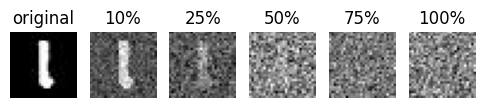

In [13]:
# Sample the first image from the next batch, then demonstrate the forward process.
def show_forward(ddpm, loader, device):
    fig = plt.figure(figsize=(6, 1))

    for batch in loader:

        images = batch[0]
        fig.add_subplot(161)
        temp = np.transpose(images[0], (1, 2, 0))
        plt.title('original')
        plt.imshow((temp+1)/2, cmap='gray')
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(0.1 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(162)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('10%')
        plt.imshow((temp+1)/2, cmap='gray')
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(0.25 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(163)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('25%')
        plt.imshow((temp+1)/2, cmap='gray')
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(0.5 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(164)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('50%')
        plt.imshow((temp+1)/2, cmap='gray')
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(0.75 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(165)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('75%')
        plt.imshow((temp+1)/2, cmap='gray')
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(1 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(166)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('100%')
        plt.imshow((temp+1)/2, cmap='gray')
        plt.axis('off')
        break

show_forward(ddpm_mnist, dataloader, device)

### Generate new images

In [14]:
"""
Provided with a DDPM model, a specified number of samples to generate, and a chosen device,
this function returns a set of freshly generated samples while also saving the .gif of the reverse process
"""
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=25, gif_name="sampling.gif", channel=1, height=28, width=28):
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, channel, height, width).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, channel, height, width).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)


    for i in range(len(frames)):
        frames[i] = cv2.cvtColor(frames[i], cv2.COLOR_GRAY2RGB)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x



### Training loop

In [15]:
def trainer(ddpm, dataloader, n_epochs, optim, loss_funciton, device, model_store_path):

    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="green"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(dataloader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="blue")):
            # Load data
            x0 = batch[0].to(device)
            n = len(x0)

            # Pick random noise for each of the images in the batch
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Compute the noisy image based on x0 and the time step
            noises = ddpm(x0, t, eta)

            # Get model estimation of noise based on the images and the time step
            eta_theta = ddpm.backward(noises, t.reshape(n, -1))

            # Optimize the Mean Squared Error (MSE) between the injected noise and the predicted noise
            loss = loss_funciton(eta_theta, eta)

            # First, initialize the optimizer's gradient and then update the network's weights
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Aggregate the loss values from each iteration to compute the loss value for an epoch
            epoch_loss += loss.item() * len(x0) / len(dataloader.dataset)

            # Save Losses for plotting later
            loss_list.append(loss.item())

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Show images generated at the epoch
        show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        # If the current loss is better than the previous one, then store the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), model_store_path)
            log_string += " <Store the best model.>"

        print(log_string)

Training progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


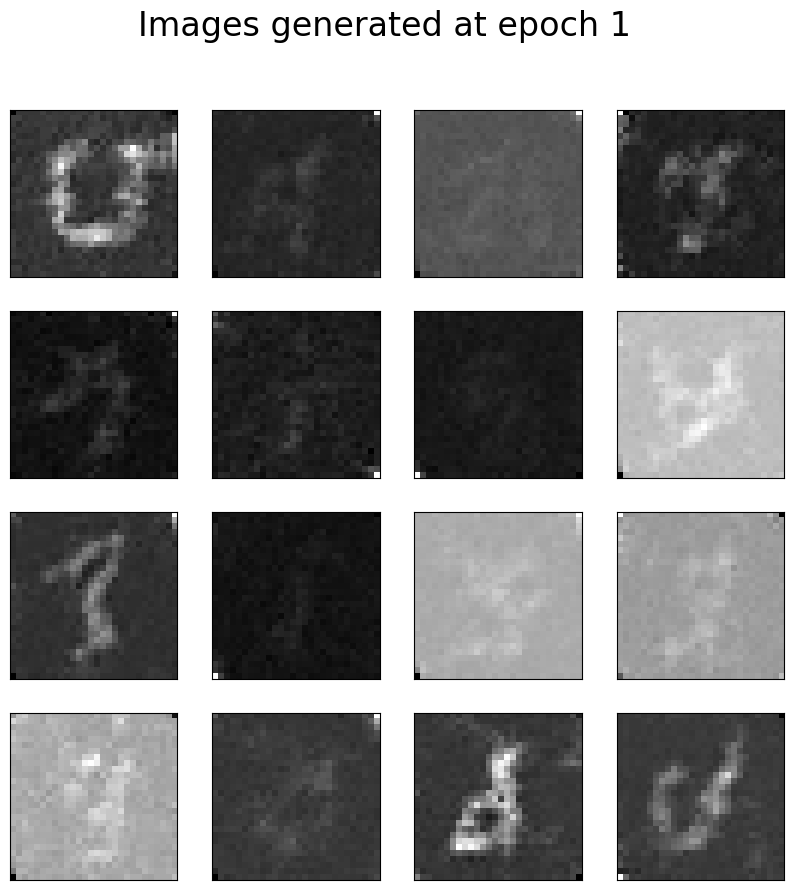

Loss at epoch 1: 0.167 <Store the best model.>


Epoch 2/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


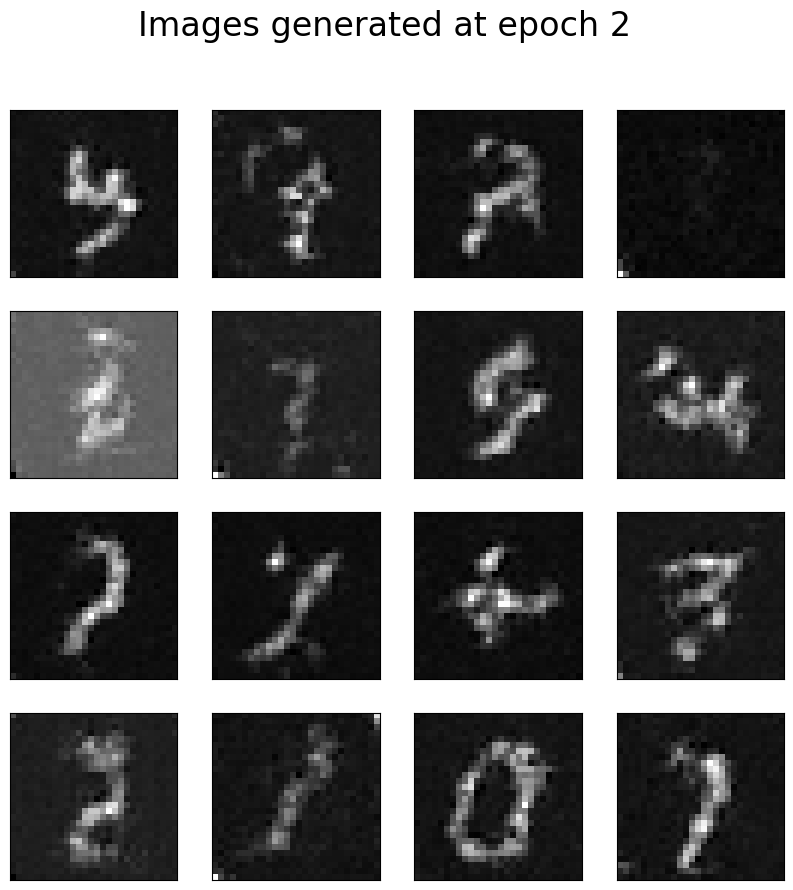

Loss at epoch 2: 0.063 <Store the best model.>


Epoch 3/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


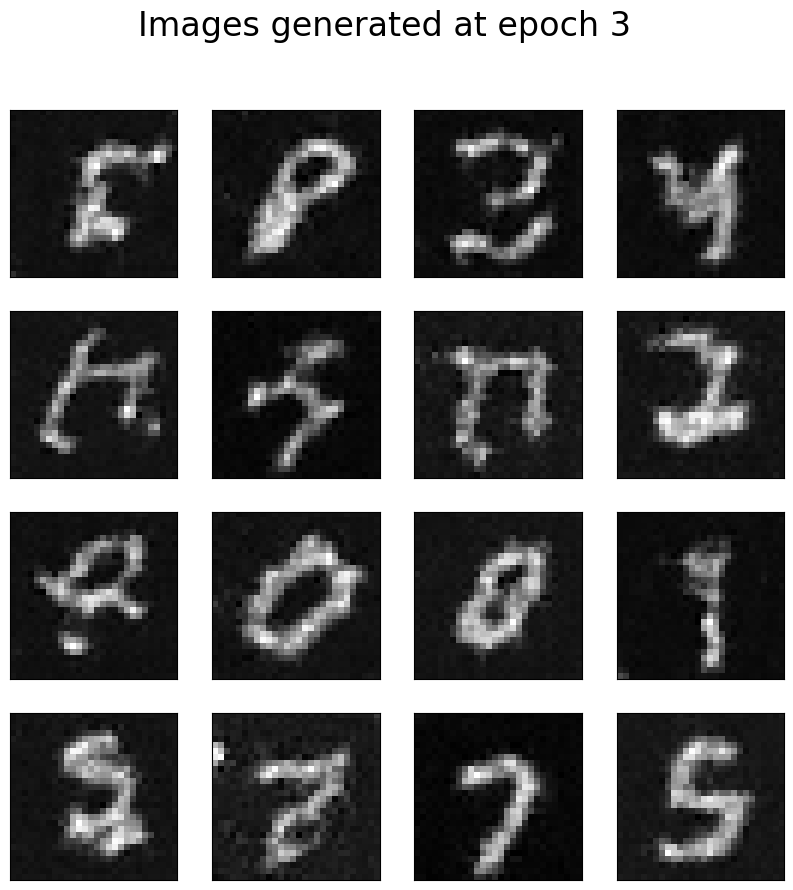

Loss at epoch 3: 0.055 <Store the best model.>


Epoch 4/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


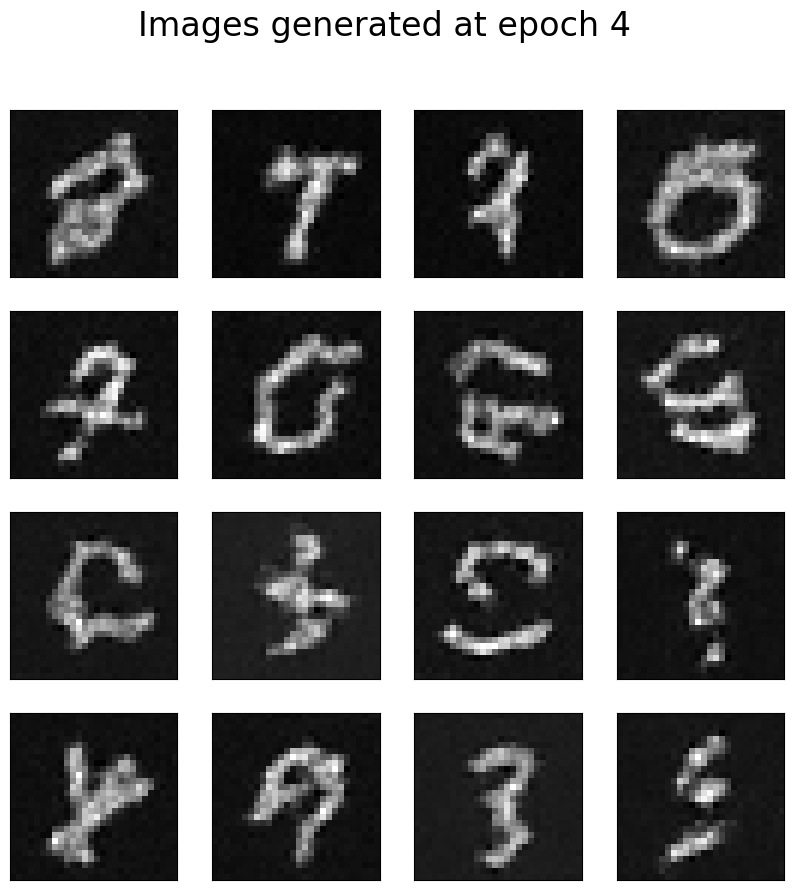

Loss at epoch 4: 0.051 <Store the best model.>


Epoch 5/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


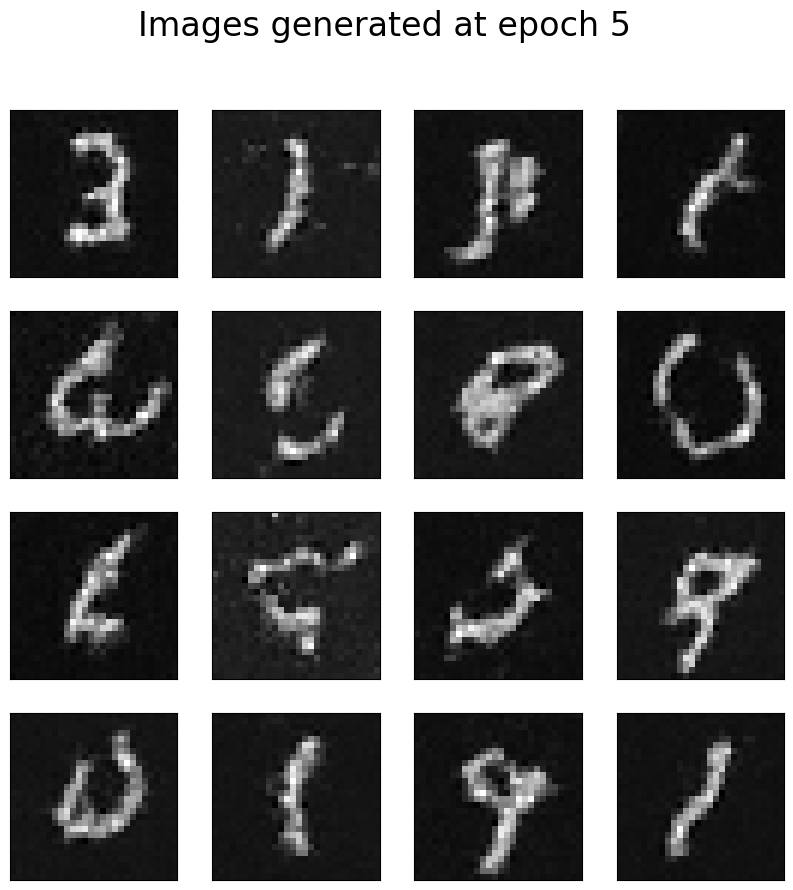

Loss at epoch 5: 0.050 <Store the best model.>


Epoch 6/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


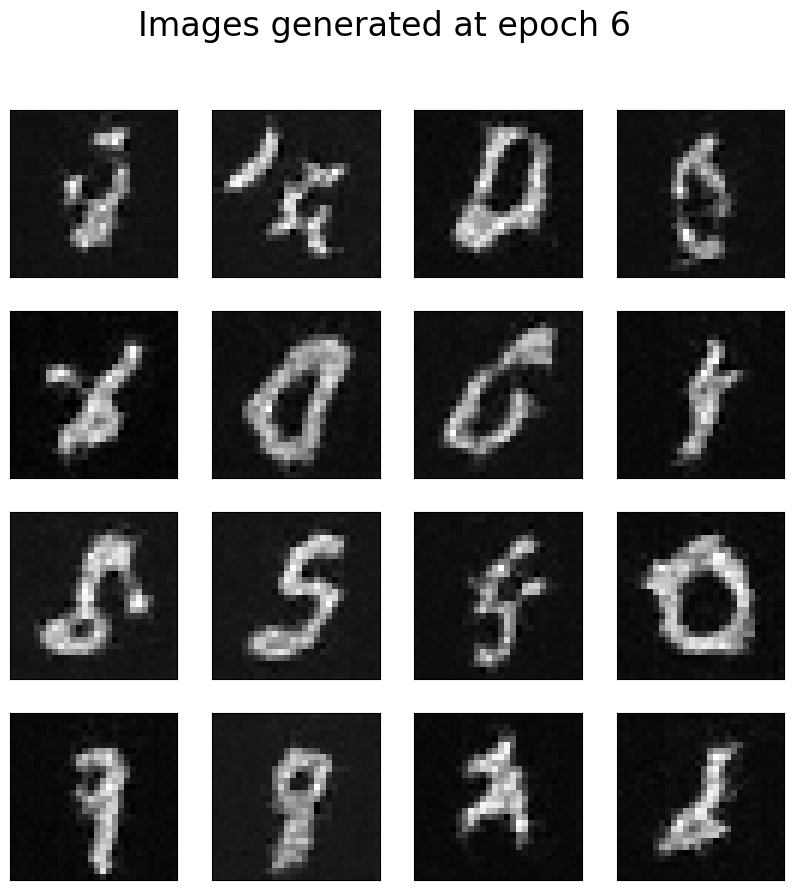

Loss at epoch 6: 0.048 <Store the best model.>


Epoch 7/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


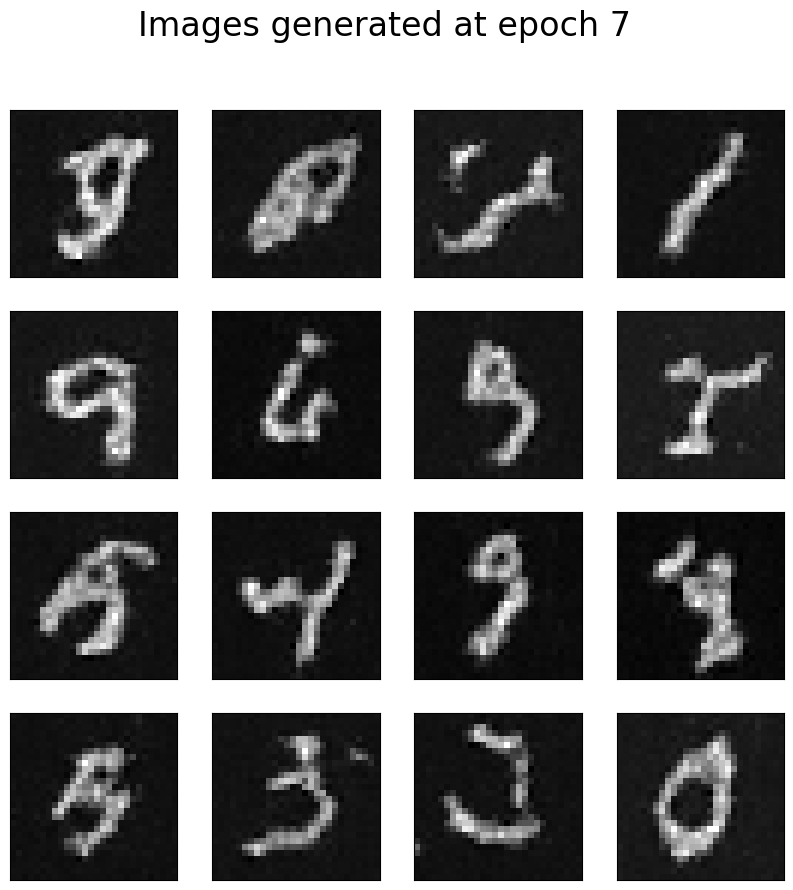

Loss at epoch 7: 0.047 <Store the best model.>


Epoch 8/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


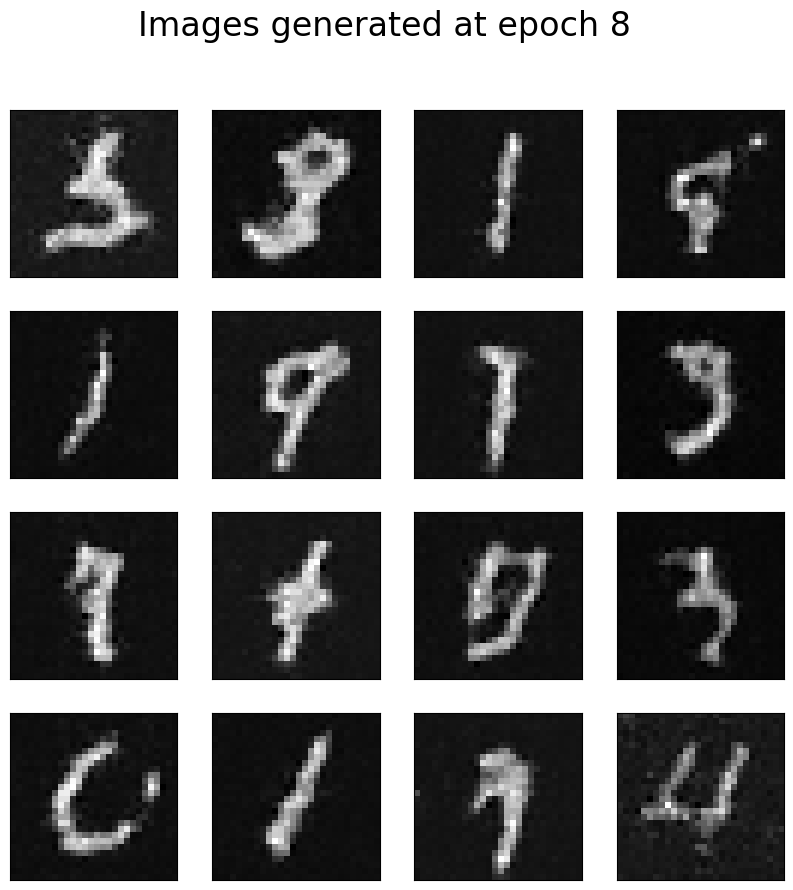

Loss at epoch 8: 0.046 <Store the best model.>


Epoch 9/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


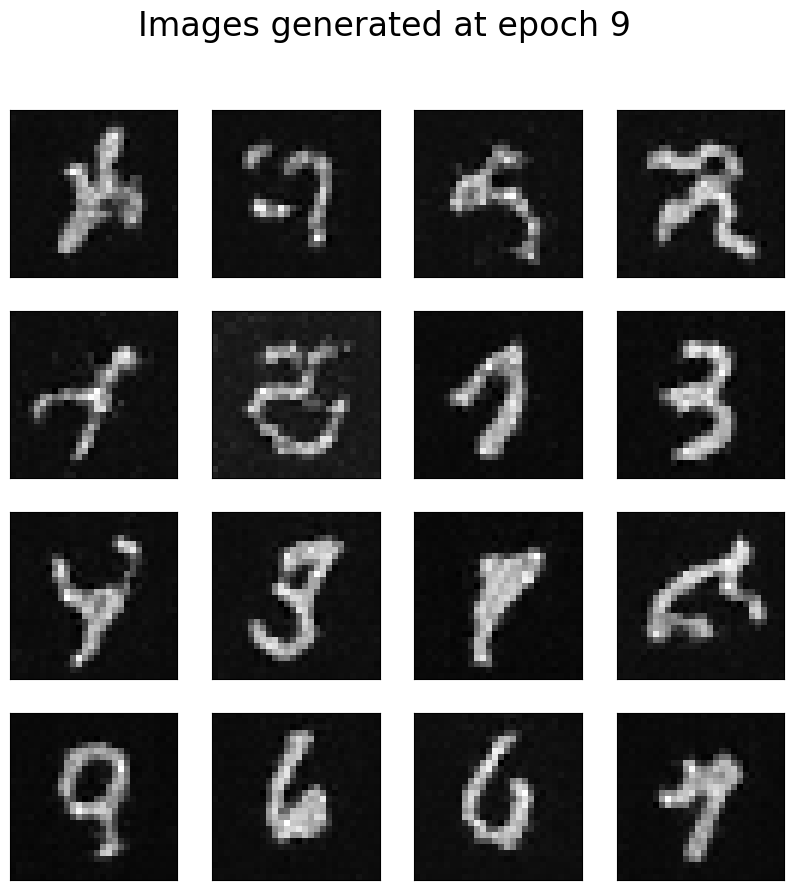

Loss at epoch 9: 0.045 <Store the best model.>


Epoch 10/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


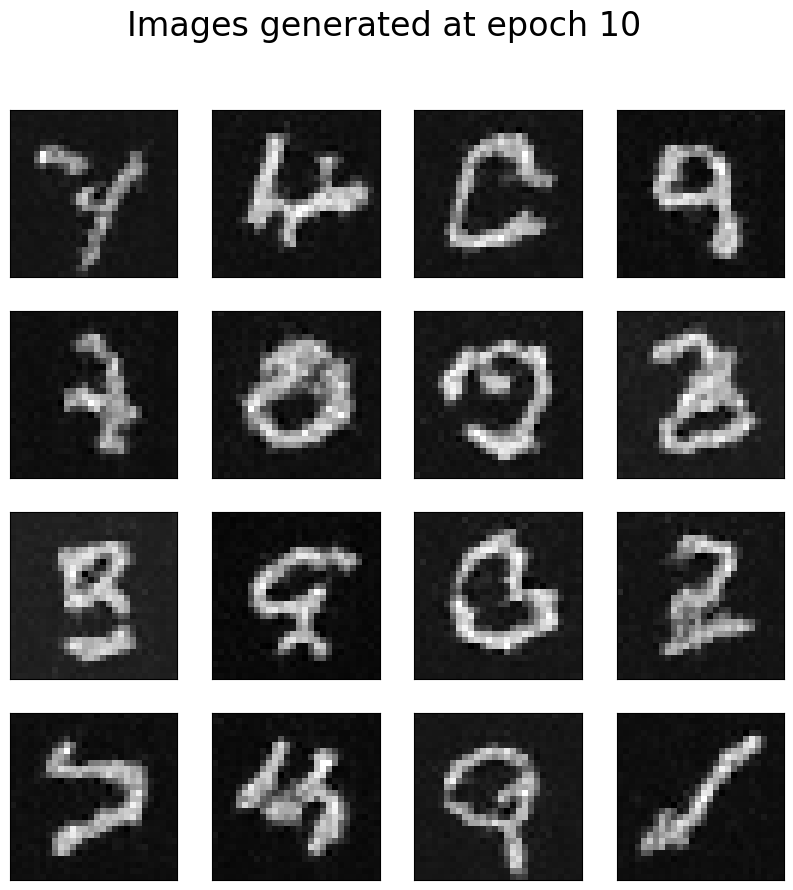

Loss at epoch 10: 0.045 <Store the best model.>


Epoch 11/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


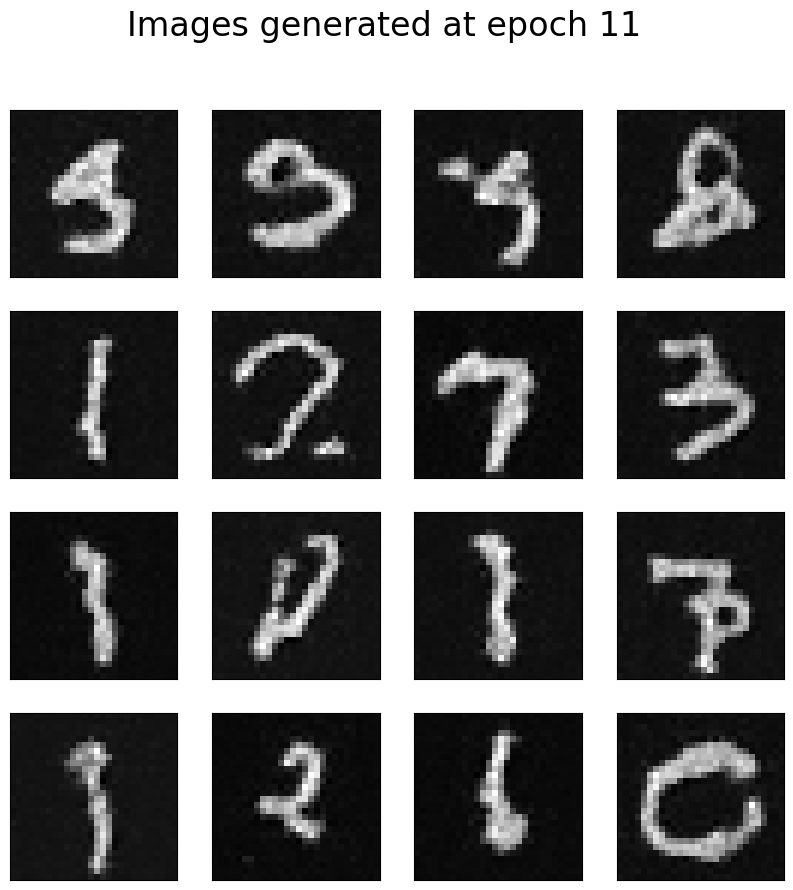

Loss at epoch 11: 0.043 <Store the best model.>


Epoch 12/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


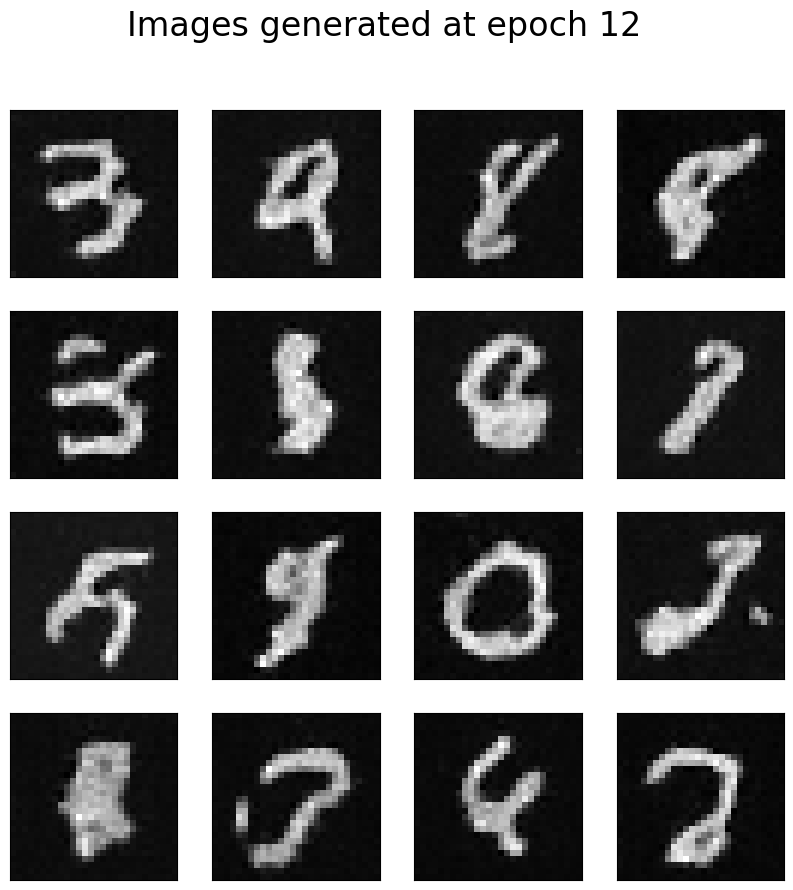

Loss at epoch 12: 0.043 <Store the best model.>


Epoch 13/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


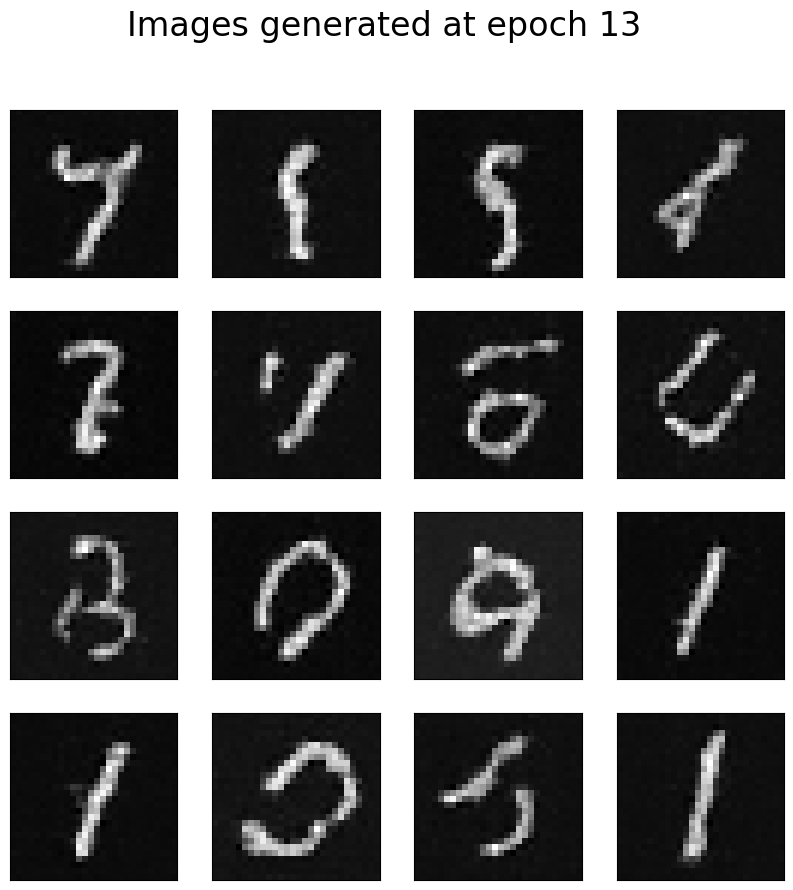

Loss at epoch 13: 0.042 <Store the best model.>


Epoch 14/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


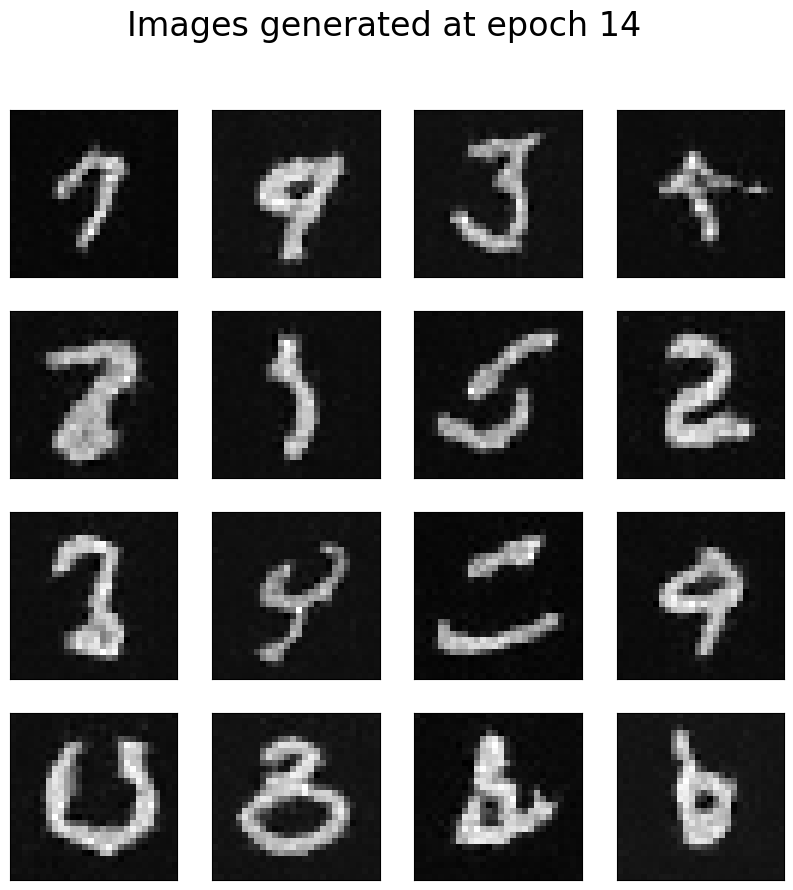

Loss at epoch 14: 0.042 <Store the best model.>


Epoch 15/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


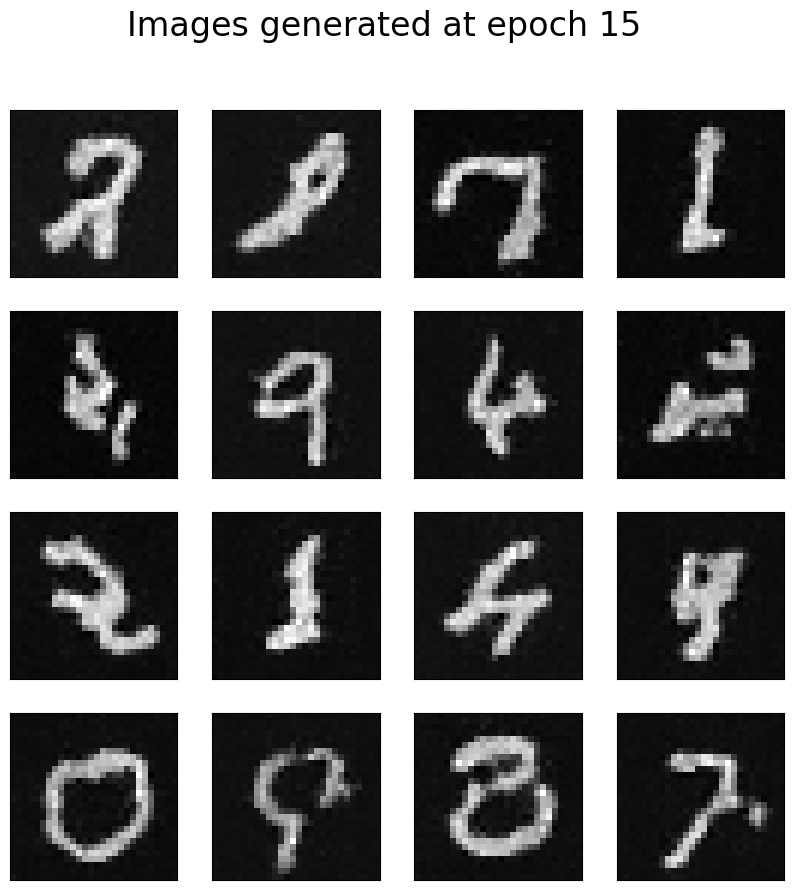

Loss at epoch 15: 0.042


Epoch 16/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


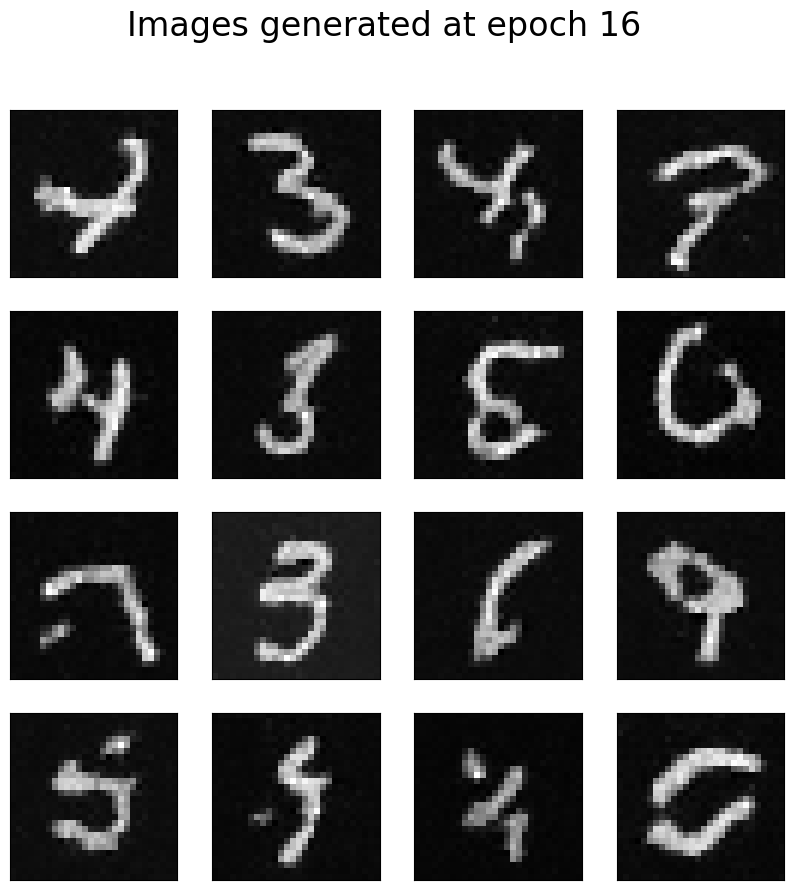

Loss at epoch 16: 0.042 <Store the best model.>


Epoch 17/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


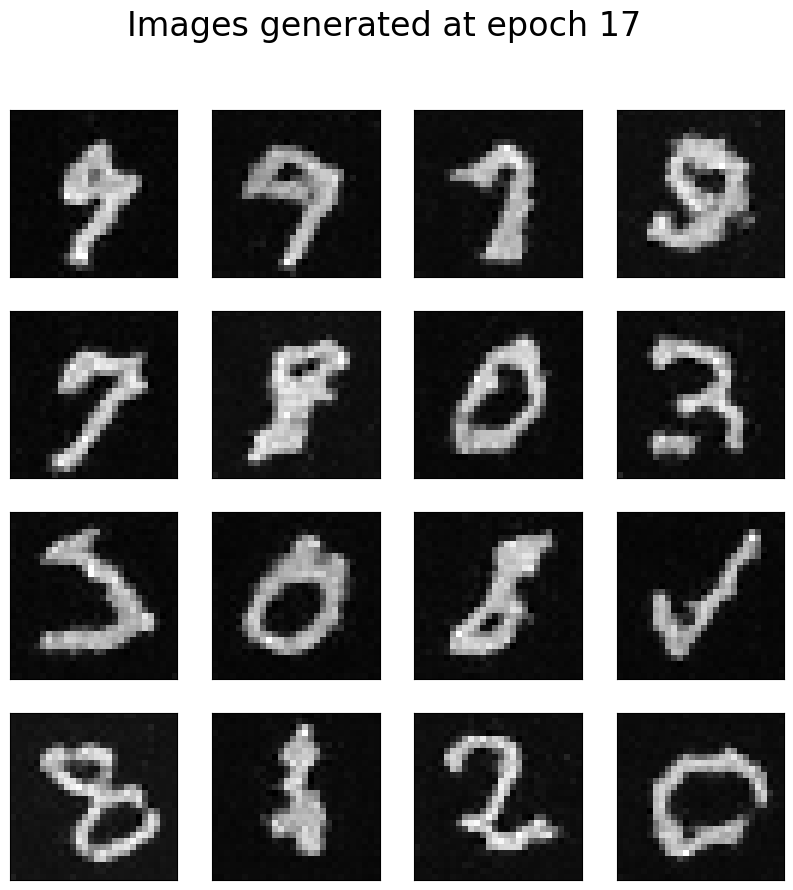

Loss at epoch 17: 0.041 <Store the best model.>


Epoch 18/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


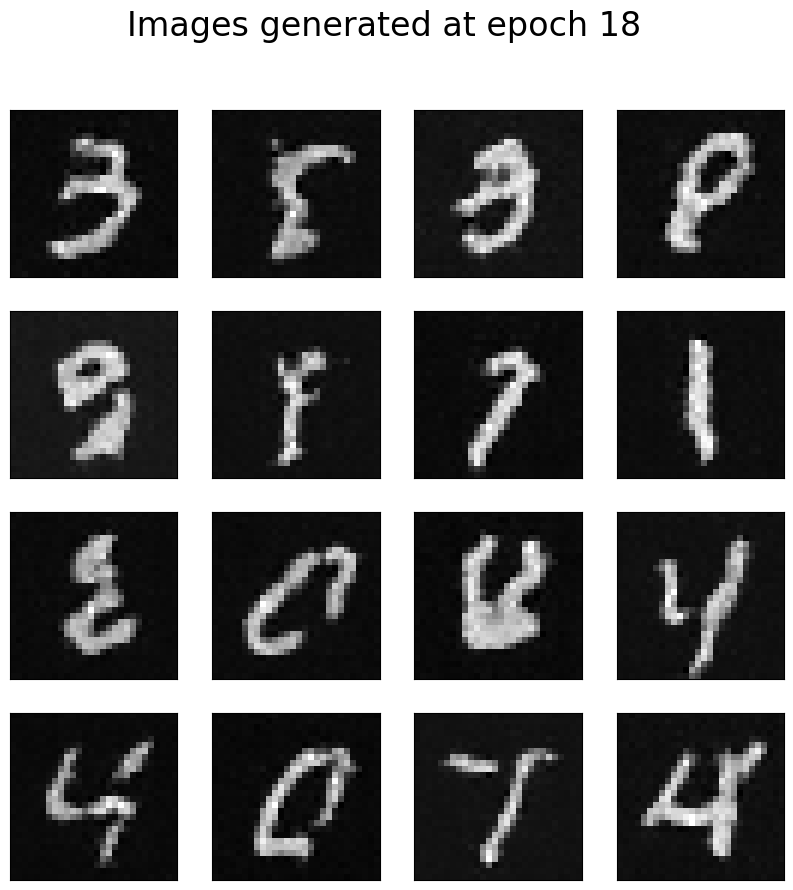

Loss at epoch 18: 0.040 <Store the best model.>


Epoch 19/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


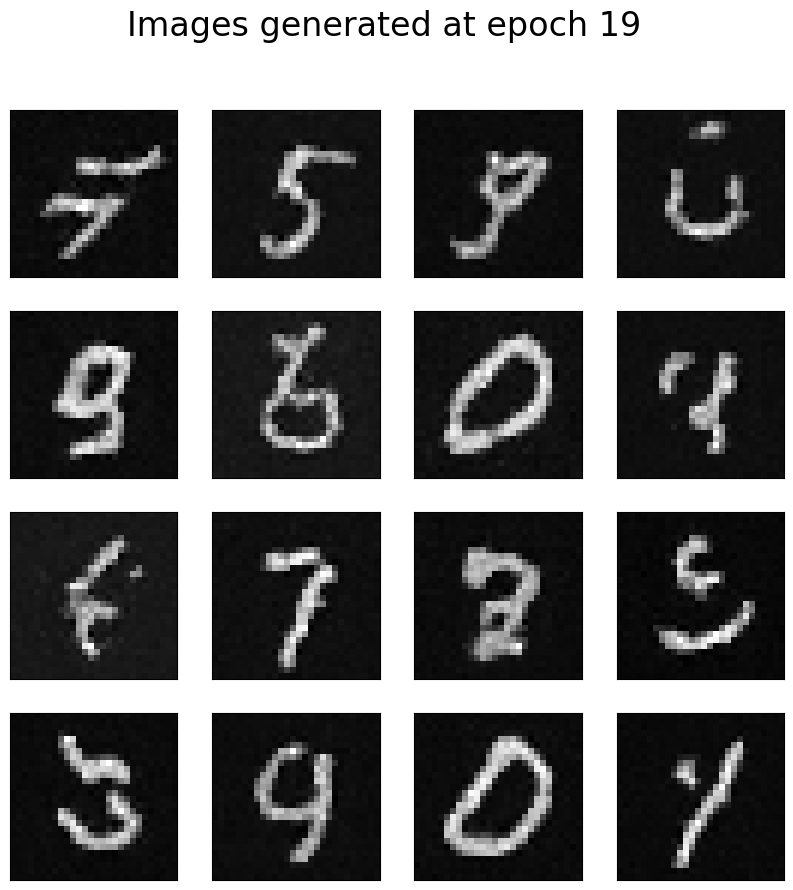

Loss at epoch 19: 0.041


Epoch 20/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


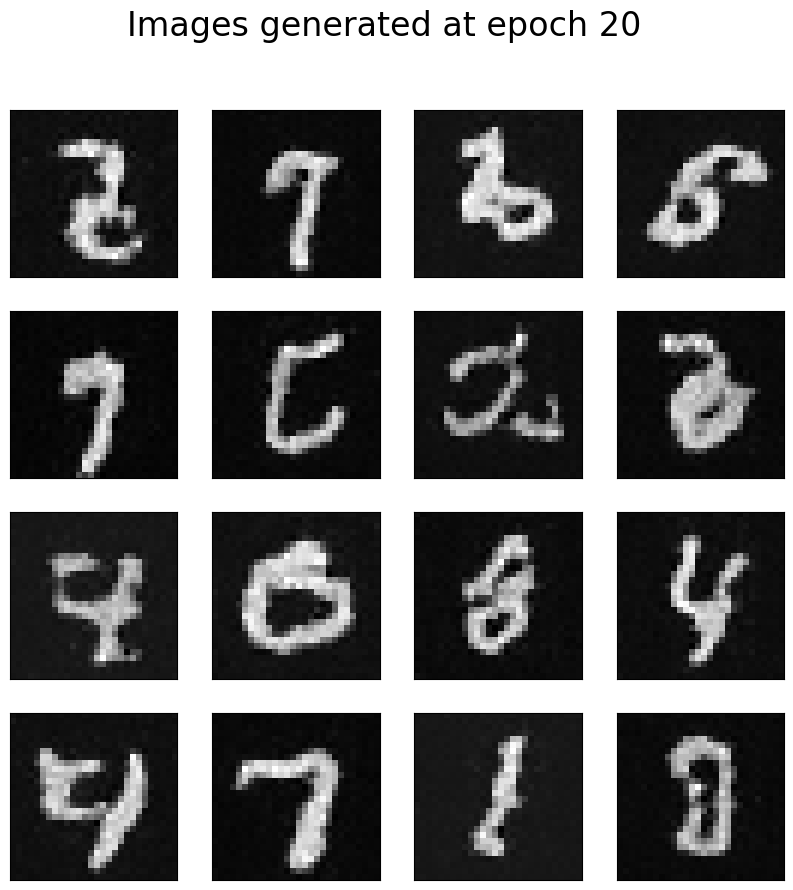

Loss at epoch 20: 0.040 <Store the best model.>


Epoch 21/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


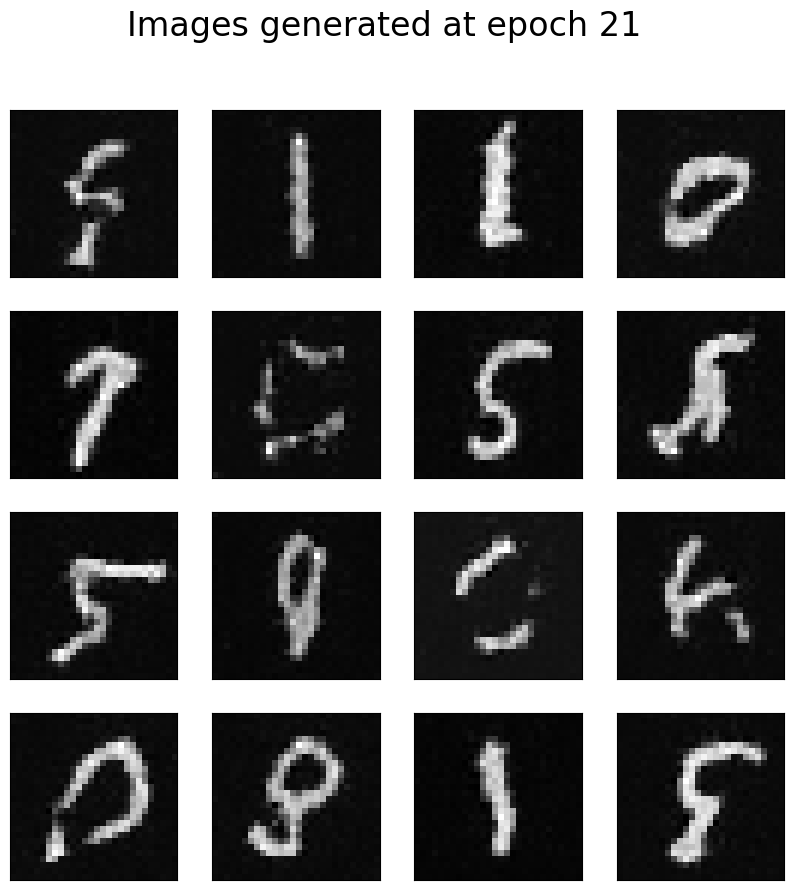

Loss at epoch 21: 0.040 <Store the best model.>


Epoch 22/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


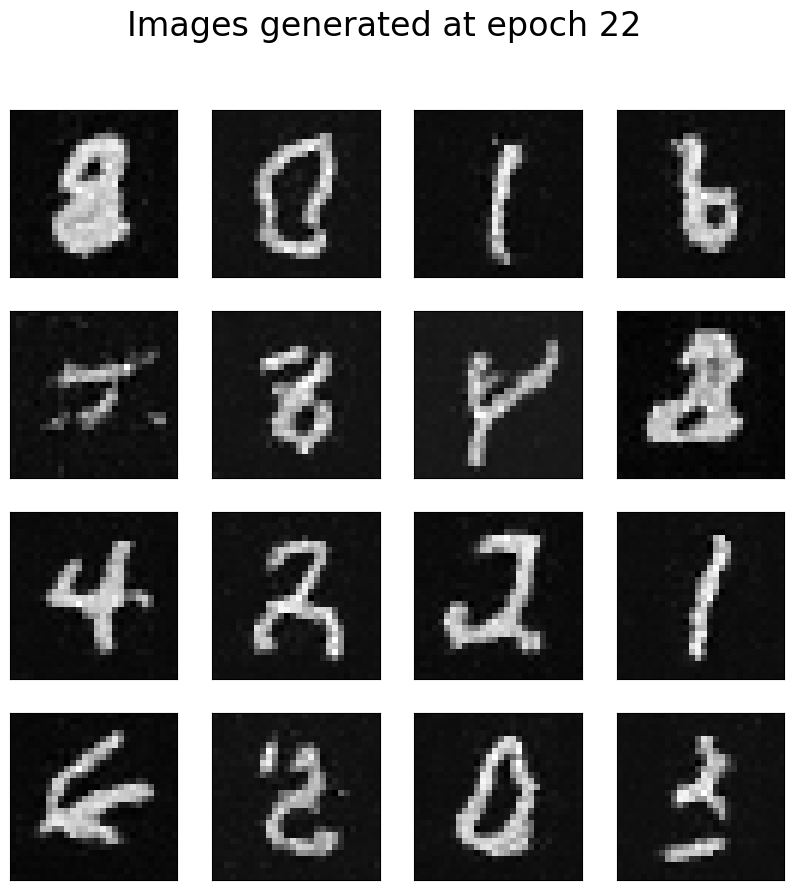

Loss at epoch 22: 0.039 <Store the best model.>


Epoch 23/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


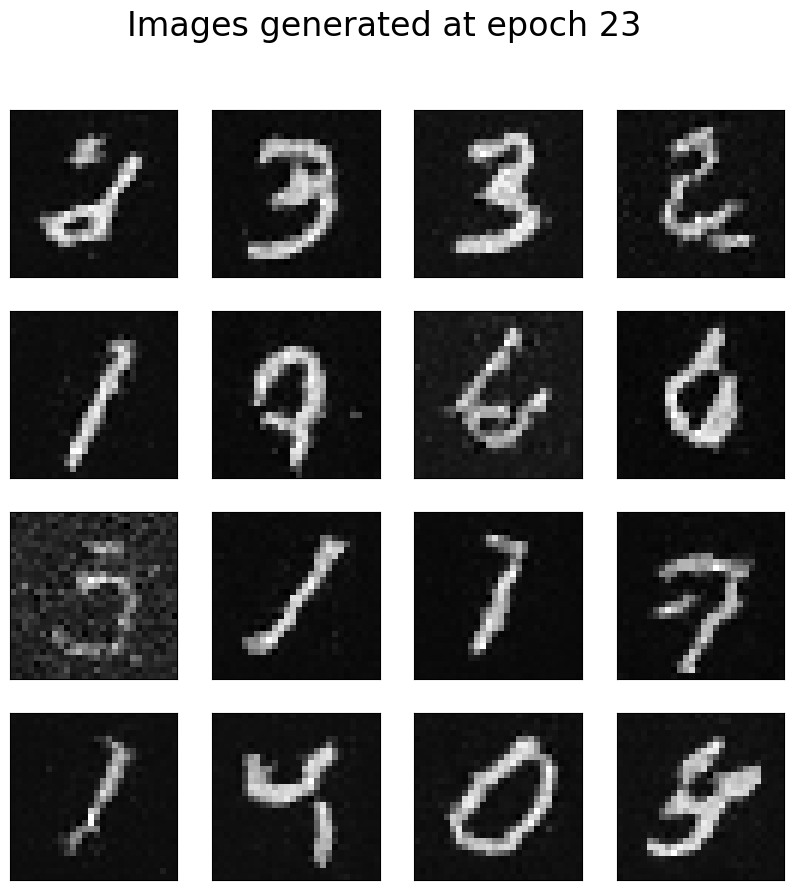

Loss at epoch 23: 0.039 <Store the best model.>


Epoch 24/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


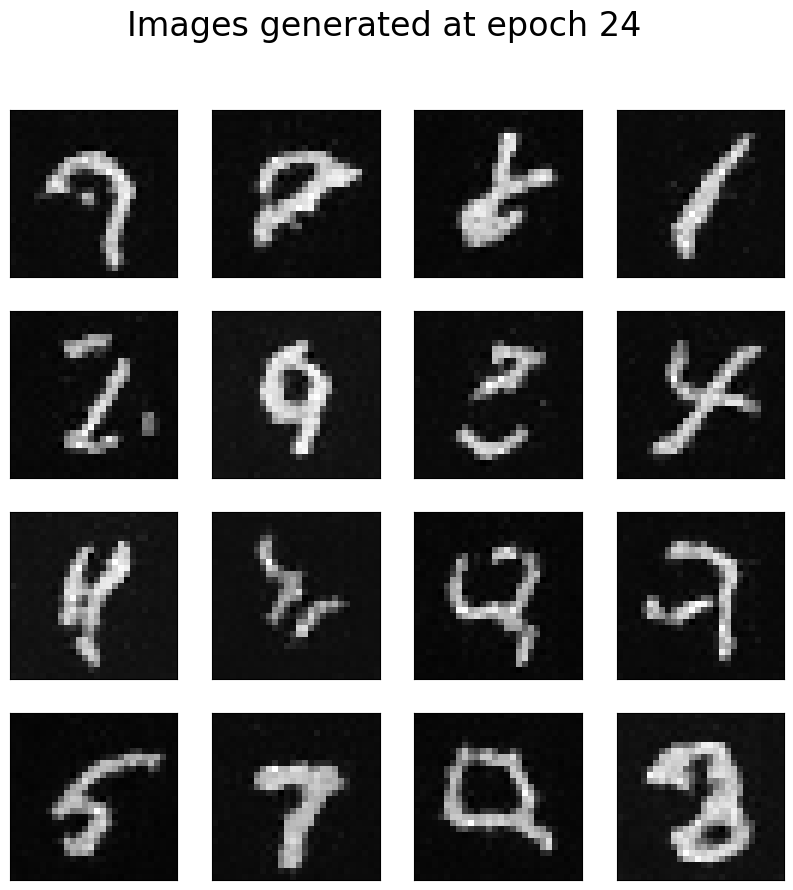

Loss at epoch 24: 0.040


Epoch 25/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


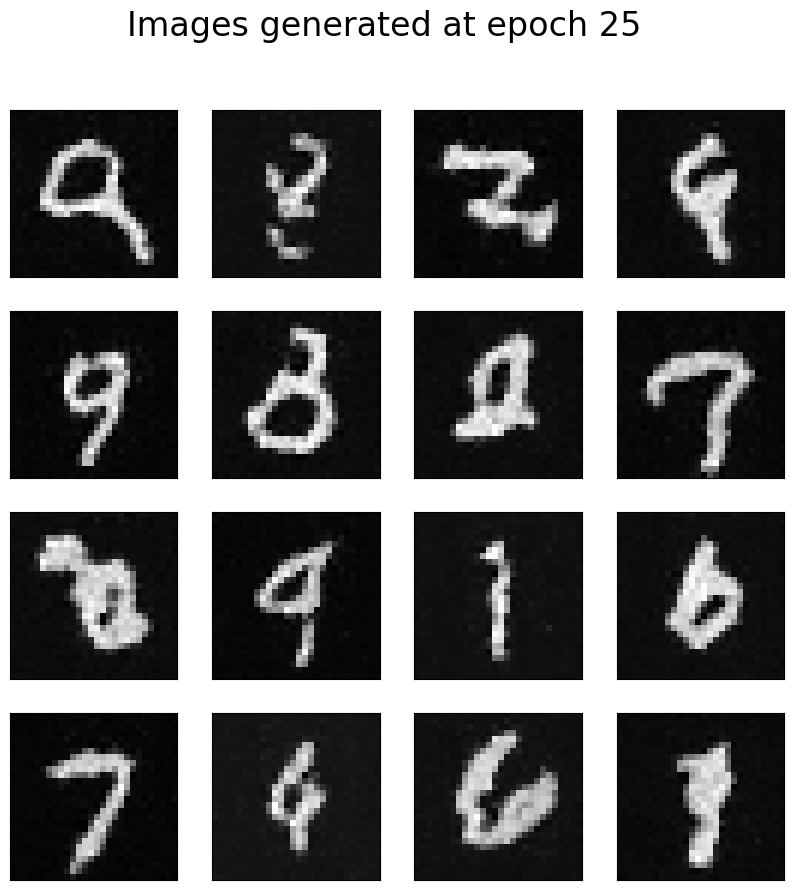

Loss at epoch 25: 0.039


Epoch 26/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


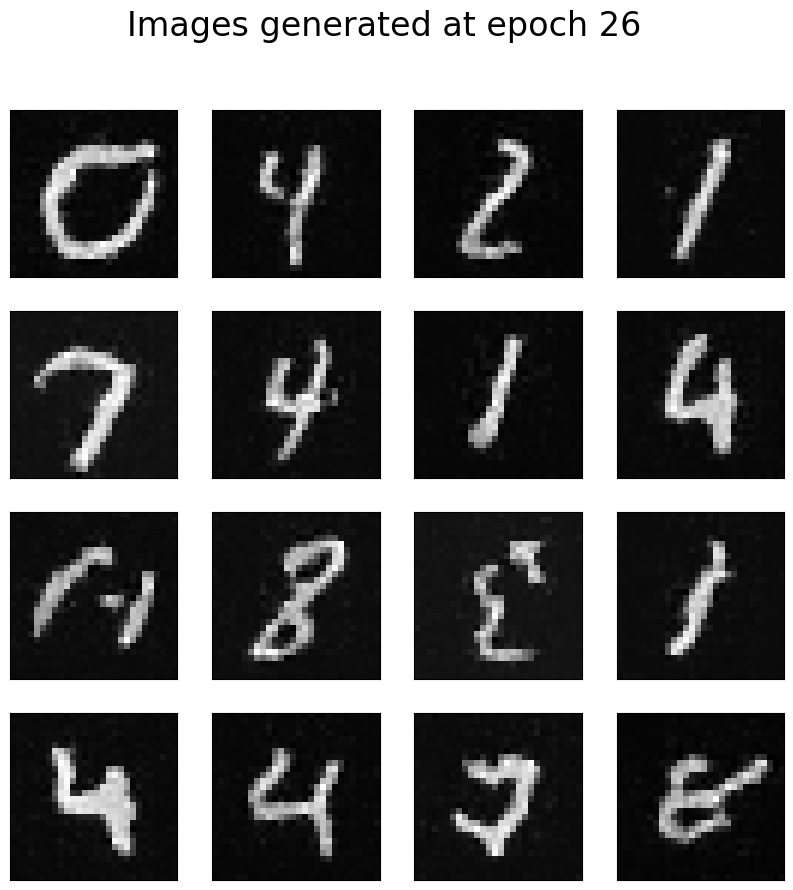

Loss at epoch 26: 0.039 <Store the best model.>


Epoch 27/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


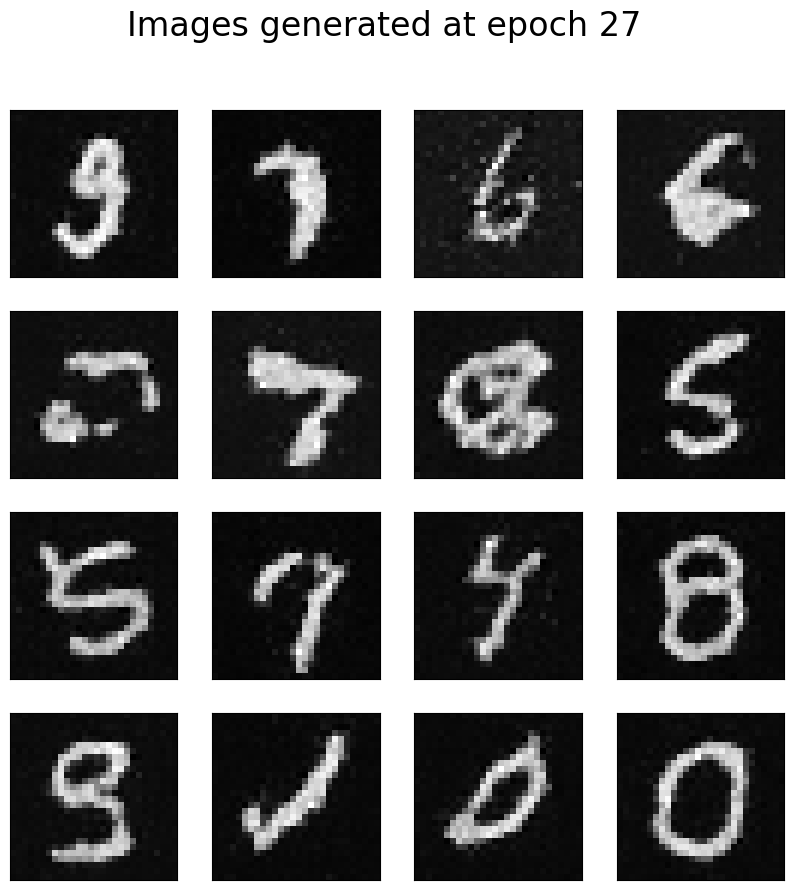

Loss at epoch 27: 0.038 <Store the best model.>


Epoch 28/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


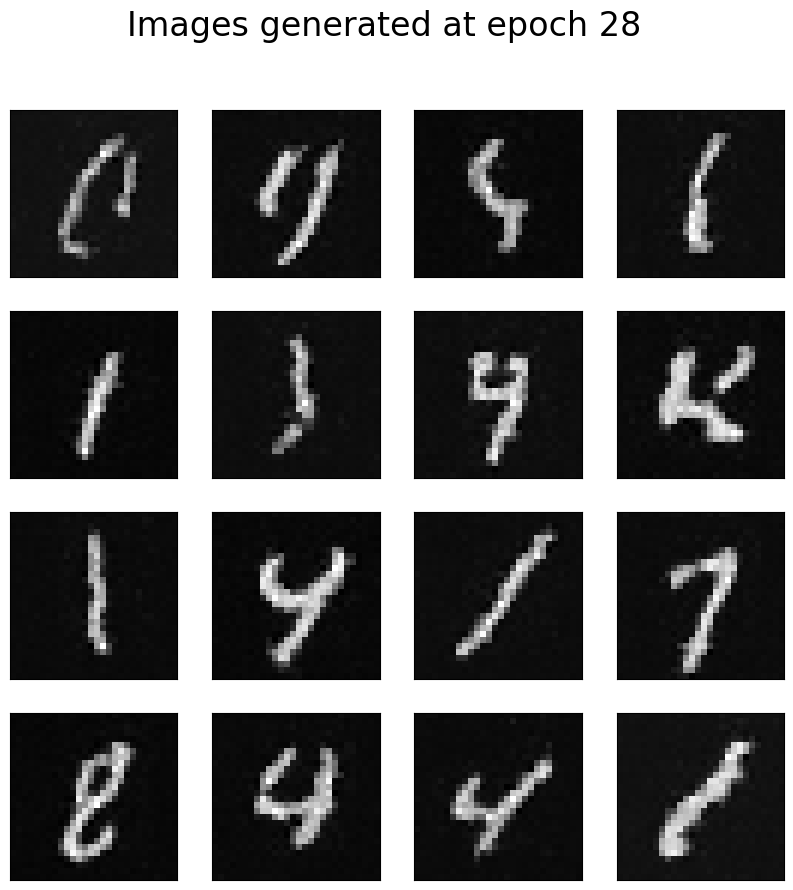

Loss at epoch 28: 0.039


Epoch 29/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


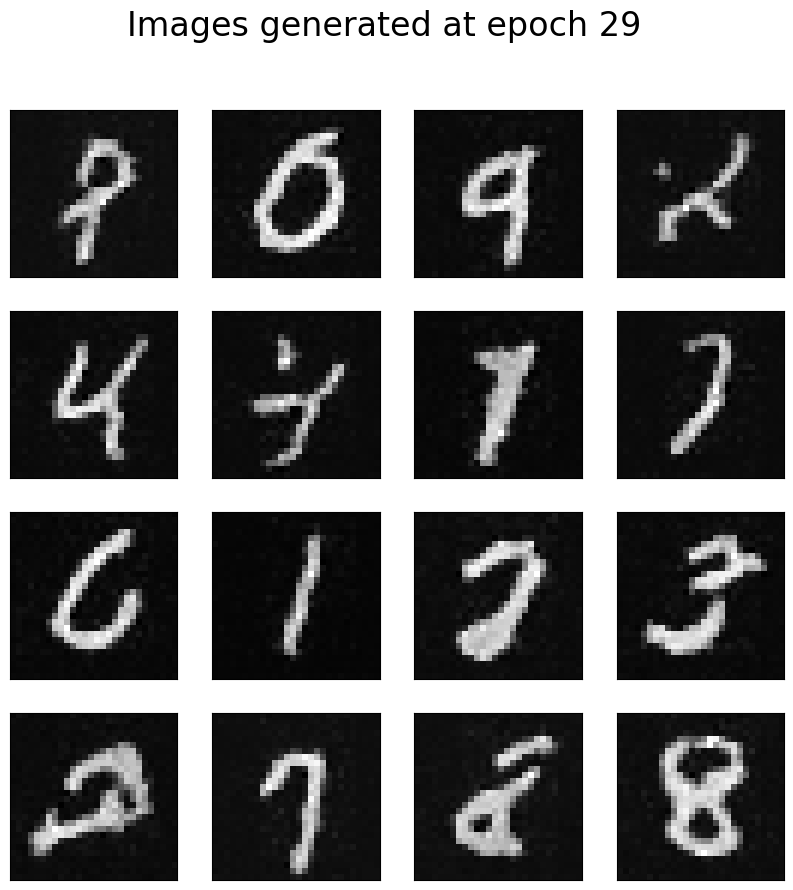

Loss at epoch 29: 0.039


Epoch 30/30:   0%|          | 0/469 [00:00<?, ?it/s]

The shape of images:  (16, 1, 28, 28)


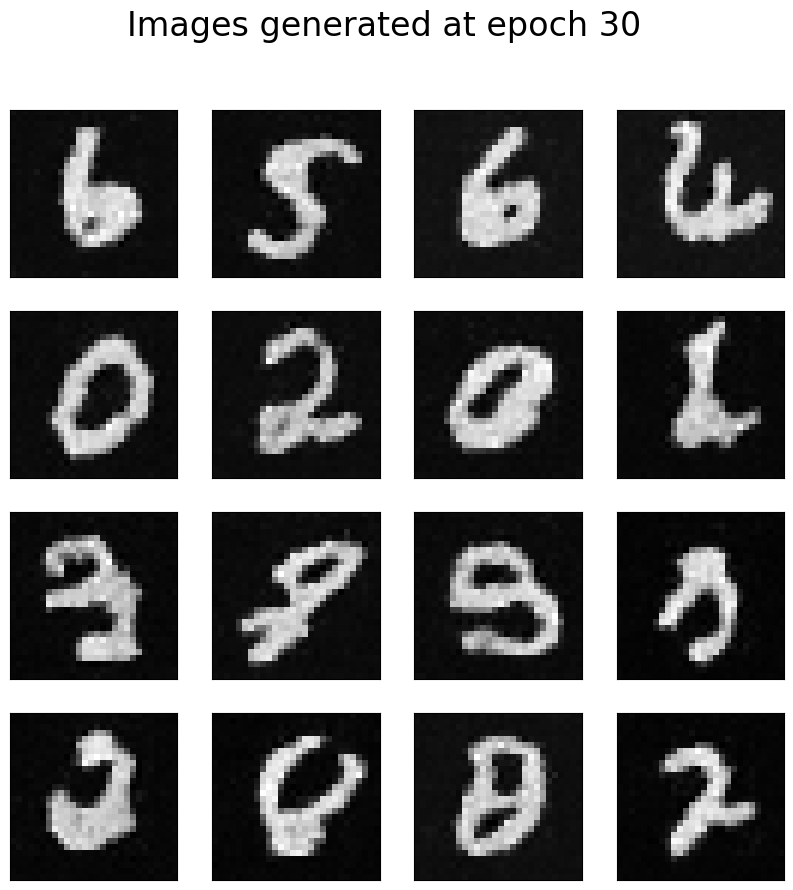

Loss at epoch 30: 0.038 <Store the best model.>


In [16]:
trainer(ddpm_mnist, dataloader, n_epochs=n_epochs, optim=Adam(ddpm_mnist.parameters(), lr), loss_funciton=nn.MSELoss(), device=device, model_store_path=model_store_path)

# Generation

### Load the trained model

In [17]:
# Build the model
ddpm_mnist = DDPM(n_steps=n_steps, device=device)

# Load the state of the trained model
ddpm_mnist.load_state_dict(torch.load(model_store_path, map_location=device))

# Change to evaluation mode
ddpm_mnist.eval()

DDPM(
  (noise_predictor): UNet(
    (time_step_embedding): Embedding(1000, 256)
    (time_step_encoder1): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
    (block1): Sequential(
      (0): LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)
      (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2)
    )
    (down1): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (time_step_encoder2): Sequential(
      (0): Linear(in_features=256, out_features=8, bias=True)
      (1): SiLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
    )
    (block2): Sequential(
      (0): LayerNorm((8, 14, 14), eps=1e-05, elementwise_affine=True)
      (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2)

### Generate images

The shape of images:  (100, 1, 28, 28)


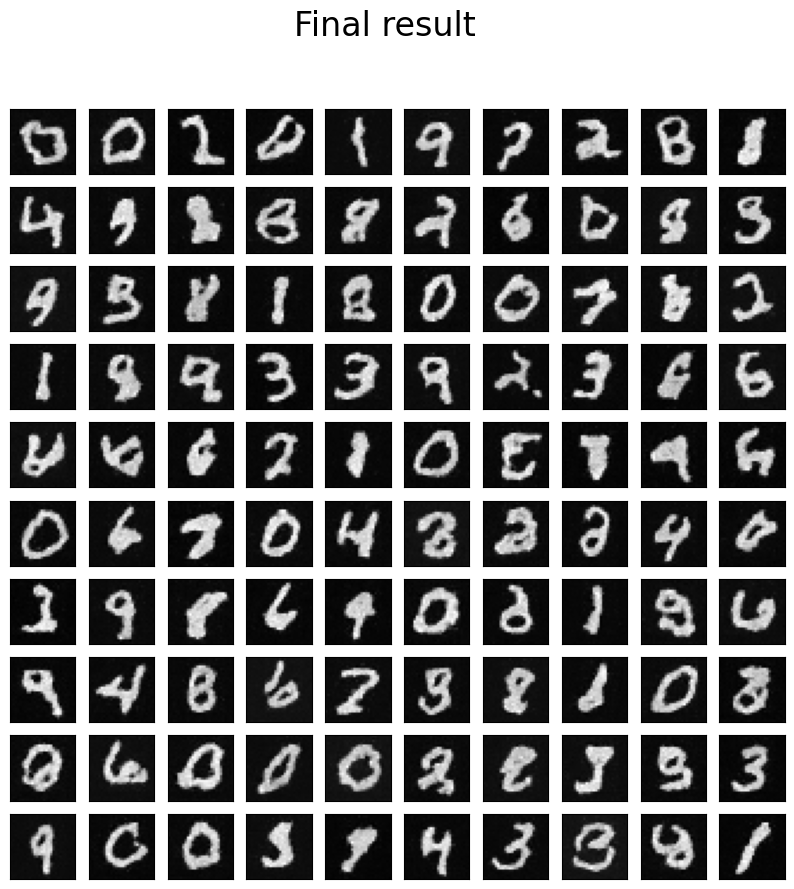

In [18]:
images = generate_new_images(
        ddpm_mnist,
        n_samples=100,
        device=device,
        gif_name="mnist.gif"
    )
show_images(images, "Final result")

### Show the GIF

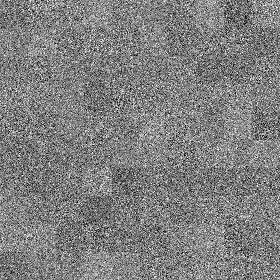

In [19]:
from IPython.display import Image

Image(open('mnist.gif','rb').read())

# Plot loss values

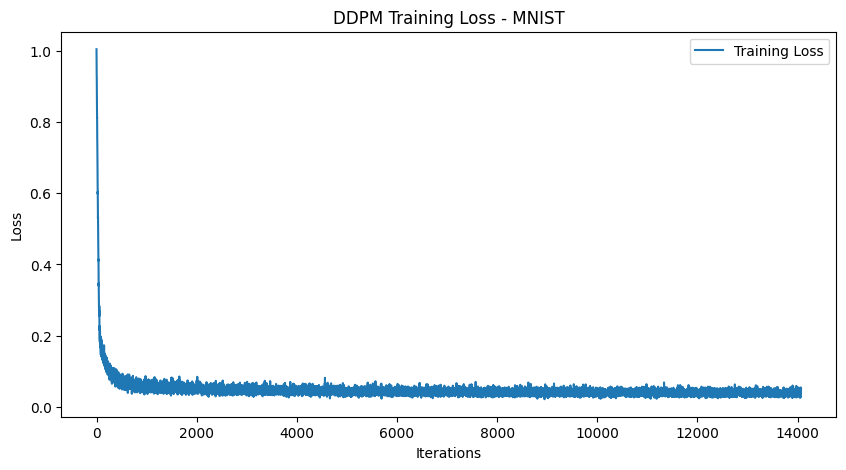

In [20]:
######################################################################################
# TODO: Plot the loss values of DDPM for the MNIST dataset
# Implementation B.1-2
######################################################################################
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Training Loss')
plt.title('DDPM Training Loss - MNIST')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_mnist.jpg')
plt.show()


# Plot generated images in 5*5 grid

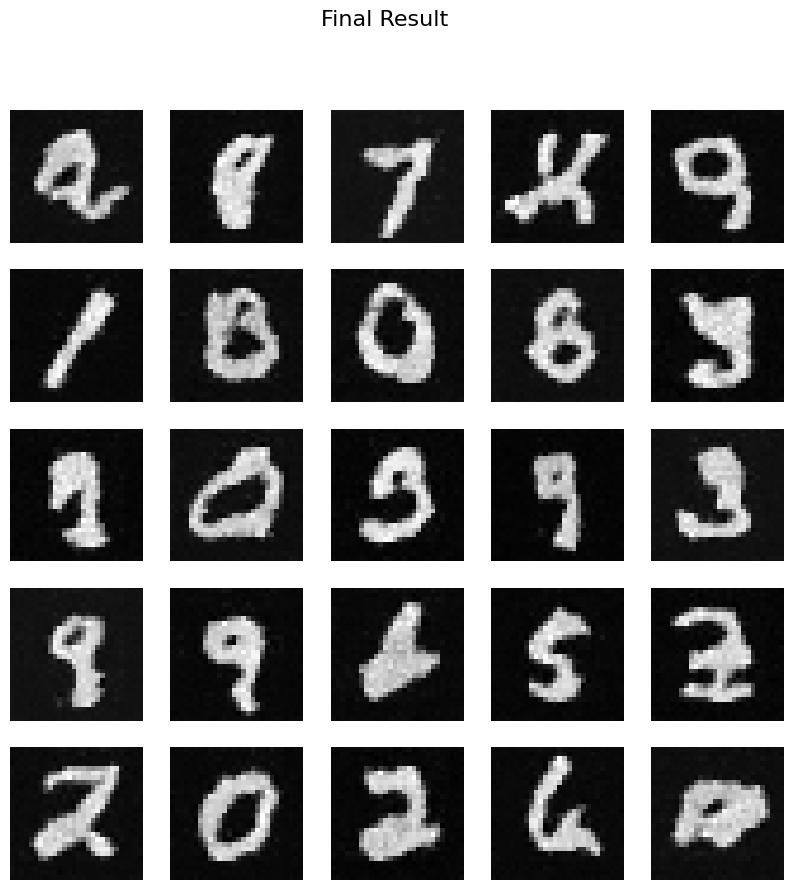

In [21]:
######################################################################################
# TODO: Store your generate images in 5*5 grid for the MNIST dataset
# Implementation B.1-3
######################################################################################
generated_images_mnist = generate_new_images(ddpm_mnist, n_samples=25, device=device).cpu().detach().numpy()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        image = generated_images_mnist[idx]
        axes[i, j].imshow(image[0], cmap='gray')
        axes[i, j].axis('off')

plt.suptitle('Final Result', fontsize=16)
plt.savefig('result_mnist.jpg')
plt.show()


# It's your turn

You need to train the diffusion model to generate grayscale images or color ones by the Anime Face dataset.

If you choose to implement the color images generation model, you will get additional bonus.

Please note that the size of the input images should be 64x64.



Training progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 1/100000:   0%|          | 0/1336 [00:00<?, ?it/s]

The shape of images:  (16, 3, 64, 64)


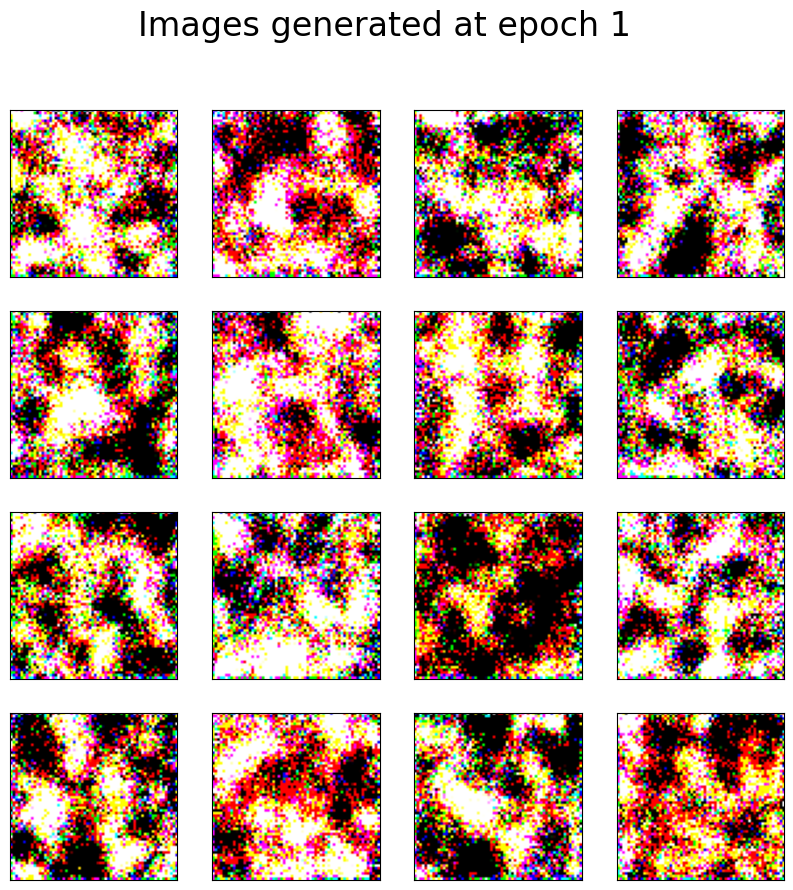

Loss at epoch 1: 0.210 <Store the best model.>


Epoch 2/100000:   0%|          | 0/1336 [00:00<?, ?it/s]

The shape of images:  (16, 3, 64, 64)


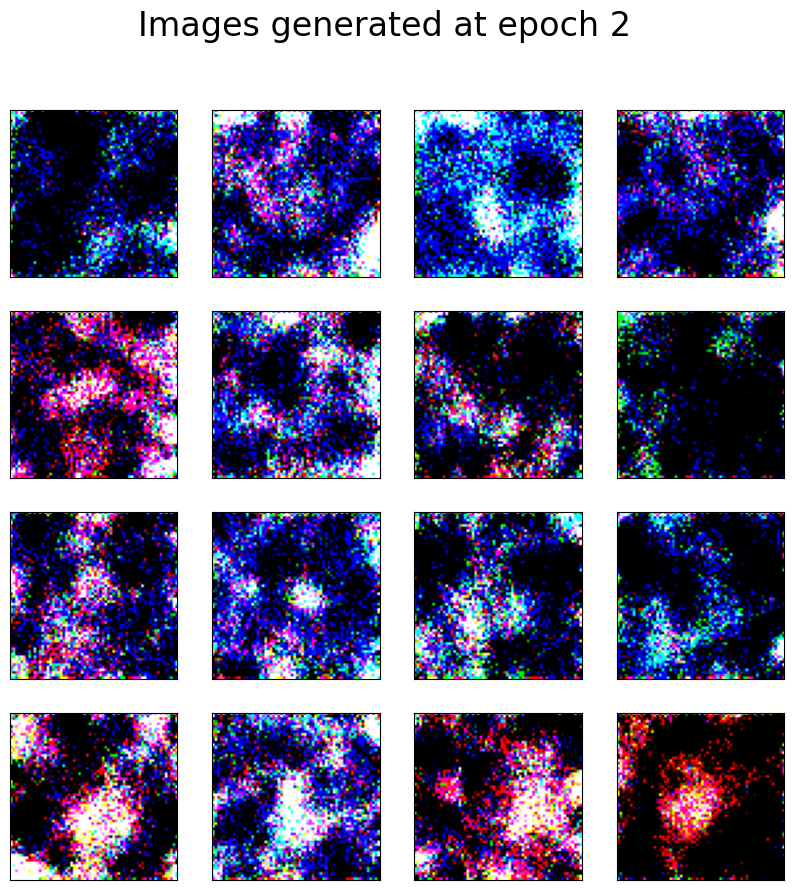

Loss at epoch 2: 0.091 <Store the best model.>


Epoch 3/100000:   0%|          | 0/1336 [00:00<?, ?it/s]

In [ ]:
######################################################################################
# TODO: Design the diffusion process for the Anime Face dataset
# Implementation B.1-4
######################################################################################
# Dataset
anime_dataset_path =  f"{workspace_dir}/anime_face_dataset" 

# Batch size during training
batch_size = 16

# Number of training epochs
n_epochs = 100000

# Learning rate for optimizers
lr = 0.0001

# Number of the forward steps
n_steps = 1000

# Initial beta
start_beta = 1e-4

# End beta
end_beta = 0.02

anime_dataset = ImageFolder(root=anime_dataset_path, transform=Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]))

anime_dataloader = DataLoader(anime_dataset, batch_size, shuffle=True)

# Define the class of U-Net
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_embedding_dim=256):
        super(UNet, self).__init__()

        # Time embedding
        self.time_step_embedding = nn.Embedding(n_steps, time_embedding_dim)
        self.time_step_embedding.weight.data = time_embedding(n_steps, time_embedding_dim)
        self.time_step_embedding.requires_grad_(False)

        # The first half
        self.time_step_encoder1 = nn.Sequential(
            nn.Linear(time_embedding_dim, 1),
            nn.SiLU(),
            nn.Linear(1, 1)
        )
        #input: 64*64 output: 64*64
        self.block1 = nn.Sequential(
            nn.LayerNorm((3, 64, 64)),
            nn.Conv2d(3, 8*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8*2, 8*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        #input: 64*64 output: 32*32
        self.down1 = nn.Conv2d(8*2, 8*2, 4, 2, 1)

        self.time_step_encoder2 = nn.Sequential(
            nn.Linear(time_embedding_dim, 8*2),
            nn.SiLU(),
            nn.Linear(8*2, 8*2)
        )
        #input: 32*32 output: 32*32
        self.block2 = nn.Sequential(
            nn.LayerNorm((8*2, 32, 32)),
            nn.Conv2d(8*2, 16*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16*2, 16*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        #input: 32*32 output: 16*16
        self.down2 = nn.Conv2d(16*2, 16*2, 4, 2, 1)

        self.time_step_encoder3 = nn.Sequential(
            nn.Linear(time_embedding_dim, 16*2),
            nn.SiLU(),
            nn.Linear(16*2, 16*2)
        )
        #input: 16*16 output: 16*16
        self.block3 = nn.Sequential(
            nn.LayerNorm((16*2, 16, 16)),
            nn.Conv2d(16*2, 32*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32*2, 32*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        #input: 16*16 output: 8*8
        self.down3 = nn.Sequential(
            #nn.Conv2d(32, 32, 2, 1),
            #nn.LeakyReLU(0.2),
            #nn.Conv2d(32, 32, 4, 2, 1)
            nn.Conv2d(32*2, 32*2, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32*2, 32*2, 3, 2, 1)
        )

        # The bottleneck
        self.time_step_encoder_mid = nn.Sequential(
            nn.Linear(time_embedding_dim, 32*2),
            nn.SiLU(),
            nn.Linear(32*2, 32*2)
        )
        #input: 8*8 output: 8*8
        self.block_mid = nn.Sequential(
            nn.LayerNorm((32*2, 8, 8)),
            nn.Conv2d(32*2, 32*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32*2, 32*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )

        # The second half
        #input: 8*8 output: 16*16
        self.up1 = nn.Sequential(
            #nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            #nn.LeakyReLU(0.2),
            #nn.ConvTranspose2d(32, 32, 2, 1)
            nn.ConvTranspose2d(32*2, 32*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32*2, 32*2, kernel_size=3, stride=1, padding=1),
        )

        self.time_step_encoder4 = nn.Sequential(
            nn.Linear(time_embedding_dim, 64*2),
            nn.SiLU(),
            nn.Linear(64*2, 64*2)
        )
        #input: 16*16 output: 16*16
        self.block4 = nn.Sequential(
            nn.LayerNorm((64*2, 16, 16)),
            nn.Conv2d(64*2, 16*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16*2, 16*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        #input: 16*16 output: 32*32
        self.up2 = nn.ConvTranspose2d(16*2, 16*2, 4, 2, 1)

        self.time_step_encoder5 = nn.Sequential(
            nn.Linear(time_embedding_dim, 32*2),
            nn.SiLU(),
            nn.Linear(32*2, 32*2)
        )
        #input: 32*32 output: 32*32
        self.block5 = nn.Sequential(
            nn.LayerNorm((32*2, 32, 32)),
            nn.Conv2d(32*2, 8*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8*2, 8*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        #input: 32*32 output: 64*64
        self.up3 = nn.ConvTranspose2d(8*2, 8*2, 4, 2, 1)

        self.time_step_encoder6 = nn.Sequential(
            nn.Linear(time_embedding_dim, 16*2),
            nn.SiLU(),
            nn.Linear(16*2, 16*2)
        )
        #input: 64*64 output: 64*64
        self.block6 = nn.Sequential(
            nn.LayerNorm((16*2, 64, 64)),
            nn.Conv2d(16*2, 8*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8*2, 8*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.LayerNorm((8*2, 64, 64)),
            nn.Conv2d(8*2, 8*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8*2, 8*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        #input: 64*64 output: 64*64
        self.final_layer = nn.Conv2d(8*2, 3, 3, 1, 1)
        
        
    def forward(self, x, t):
        t = self.time_step_embedding(t)
        n = len(x)
        output1 = self.block1(x + self.time_step_encoder1(t).reshape(n, -1, 1, 1))
        output2 = self.block2(self.down1(output1) + self.time_step_encoder2(t).reshape(n, -1, 1, 1))
        output3 = self.block3(self.down2(output2) + self.time_step_encoder3(t).reshape(n, -1, 1, 1))
        output_mid = self.block_mid(self.down3(output3) + self.time_step_encoder_mid(t).reshape(n, -1, 1, 1))
        output4 = torch.cat((output3, self.up1(output_mid)), dim=1)
        output4 = self.block4(output4 + self.time_step_encoder4(t).reshape(n, -1, 1, 1))
        output5 = torch.cat((output2, self.up2(output4)), dim=1)
        output5 = self.block5(output5 + self.time_step_encoder5(t).reshape(n, -1, 1, 1))
        output6 = torch.cat((output1, self.up3(output5)), dim=1)
        output6 = self.block6(output6 + self.time_step_encoder6(t).reshape(n, -1, 1, 1))
        output = self.final_layer(output6)
        return output

# Model 
image_shape = (3, 64, 64)
ddpm_anime = DDPM(image_shape=image_shape, n_steps=n_steps, 
                  start_beta=start_beta, end_beta=end_beta, device=device)

"""
Provided with a DDPM model, a specified number of samples to generate, and a chosen device,
this function returns a set of freshly generated samples while also saving the .gif of the reverse process
"""
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=25, gif_name="sampling.gif", channel=3, height=64, width=64):
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, channel, height, width).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, channel, height, width).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)


    #for i in range(len(frames)):
    #    frames[i] = cv2.cvtColor(frames[i], cv2.COLOR_GRAY2RGB)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

# Reset loss list
loss_list = []
        
# Training
trainer(ddpm_anime, anime_dataloader, n_epochs=n_epochs, optim=Adam(ddpm_anime.parameters(), lr), 
        loss_funciton=nn.MSELoss(), device=device, model_store_path="anime.pt")

# Generation
ddpm_anime.load_state_dict(torch.load("anime.pt", map_location=device)) 
ddpm_anime.eval()

# Plot loss values

In [ ]:
######################################################################################
# TODO: Plot the loss values of DDPM for the Anime Face dataset
# Implementation B.1-5
######################################################################################
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Training Loss')
plt.title('DDPM Training Loss - anime')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_anime.jpg')
plt.show()

# Plot generated images in 5*5 grid

In [ ]:
######################################################################################
# TODO: Store your generate images in 5*5 grid for the Anime Face dataset
# Implementation B.1-6
######################################################################################
generated_images = generate_new_images(ddpm_anime, n_samples=25, device=device).cpu().detach().numpy()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        image = generated_images[idx].transpose(1, 2, 0)  
        axes[i, j].imshow(image)
        axes[i, j].axis('off')

plt.suptitle('Generated Anime Faces', fontsize=16)
plt.savefig('result_anime.jpg') 
plt.show()

In [ ]:
# Sample the first image from the next batch, then demonstrate the forward process.
def show_forward(ddpm, loader, device):
    fig = plt.figure(figsize=(6, 1))

    for batch in loader:

        images = batch[0]
        fig.add_subplot(161)
        temp = np.transpose(images[0], (1, 2, 0))
        plt.title('original')
        plt.imshow((temp+1)/2)
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(0.1 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(162)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('10%')
        plt.imshow((temp+1)/2)
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(0.25 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(163)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('25%')
        plt.imshow((temp+1)/2)
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(0.5 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(164)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('50%')
        plt.imshow((temp+1)/2)
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(0.75 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(165)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('75%')
        plt.imshow((temp+1)/2)
        plt.axis('off')

        tensor_image = ddpm(images[:1].to(device), [int(1 * ddpm.n_steps) - 1])
        image = tensor_image.detach().cpu().numpy()
        fig.add_subplot(166)
        temp = np.transpose(image[0], (1, 2, 0))
        plt.title('100%')
        plt.imshow((temp+1)/2)
        plt.axis('off')
        break

show_forward(ddpm_anime, anime_dataloader, device)